In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
model_base_name = '250000spec_RAE_ExtendedRange_MoreLeftOut_Combined1Distribution_OptParams'
base_name = '250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution'    # This is the dataset base name
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [4]:
# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra_filename = f'Dataset44_{base_name}_ForManuscript_Spec.dat'
conc1_filename = f'Dataset44_{base_name}_ForManuscript_Conc.npy'

spectra_shape = (249996, 46000)
conc1_shape = (249996, 44)


# Load the memmap arrays
spectra_memmap = np.memmap(spectra_filename, dtype=np.float64, mode='r', shape=spectra_shape)
conc1_memmap = np.load(conc1_filename)

# Split into testing and training data
X_train_indices, X_test_indices, y_train_indices, y_test_indices = train_test_split(
    np.arange(spectra_shape[0]), np.arange(conc1_shape[0]), test_size=0.2, random_state=1
)

# Create custom dataset class
class NMRDataset(torch.utils.data.Dataset):
    def __init__(self, spectra_memmap, conc1_memmap, indices):
        self.spectra_memmap = spectra_memmap
        self.conc1_memmap = conc1_memmap
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        X = self.spectra_memmap[actual_idx]
        y = self.conc1_memmap[actual_idx]
        return torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)
    

# Create datasets
train_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_train_indices)
test_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_test_indices)


# Create DataLoaders
batch_size = 61  
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first = True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(47104, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = self.transformer_encoder(x)  # (batch_size, num_bins, d_model)

        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 500  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 16         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 512  # Feedforward dimension
dropout = 0.0     # Dropout rate

## Best parameters from Optuna hyperparameter optimization
#{'n_layers': 1, 
# 'input_dim': 500, 
# 'd_model': 512, 
# 'nhead': 16, 
# 'num_encoder_layers': 1, 
# 'dim_feedforward': 512, 
# 'bs': 61, 
# 'learning_rate': 0.0004977471527512947, 
# 'reg_strength': 0.009588510882049478}

In [7]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [8]:
from torch.cuda.amp import GradScaler, autocast

def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.0004977471527512947, weight_decay=0.009588510882049478)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping
    accumulation_steps = 4
    
    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        ## Training phase
        # Instantiate the GradScaler
        scaler = GradScaler()
        optimizer.zero_grad()  # Only zero gradients here at the start of an epoch
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Enable autocasting for forward and backward passes
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Scale the loss to account for the accumulation steps
                loss = loss / accumulation_steps
            train_loss += loss.item() * inputs.size(0)
            # Scale the loss and perform backpropagation
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Step the optimizer and update the scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Zero gradients after accumulation_steps

        # Testing phase
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
        
        
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [9]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 19750.2265, Test Loss: 8236.4072
Epoch time:  468.7970173358917
Epoch [2/1000], Train Loss: 4842.9130, Test Loss: 3044.5753
Epoch time:  65.24609971046448
Epoch [3/1000], Train Loss: 2367.1438, Test Loss: 1760.6963
Epoch time:  64.95705652236938
Epoch [4/1000], Train Loss: 1763.2607, Test Loss: 1581.0308
Epoch time:  65.02956295013428
Epoch [5/1000], Train Loss: 1898.1735, Test Loss: 1322.2088
Epoch time:  65.07134461402893
Epoch [6/1000], Train Loss: 1253.4564, Test Loss: 1148.9546
Epoch time:  64.91779565811157
Epoch [7/1000], Train Loss: 1462.5942, Test Loss: 1138.0853
Epoch time:  65.07359004020691
Epoch [8/1000], Train Loss: 1126.8761, Test Loss: 1236.4098
Epoch time:  64.77237153053284
Epoch [9/1000], Train Loss: 1704.2128, Test Loss: 14847.4648
Epoch time:  64.85686421394348
Epoch [10/1000], Train Loss: 1470.1190, Test Loss: 950.6151
Epoch time:  65.19089126586914
Epoch [11/1000], Train Loss: 966.4403,

Epoch [92/1000], Train Loss: 452.2561, Test Loss: 437.7876
Epoch time:  202.58600401878357
Epoch [93/1000], Train Loss: 455.2638, Test Loss: 423.2682
Epoch time:  216.6645953655243
Epoch [94/1000], Train Loss: 917.5378, Test Loss: 399.1215
Epoch time:  214.7030999660492
Epoch [95/1000], Train Loss: 424.6246, Test Loss: 410.3100
Epoch time:  208.33694338798523
Epoch [96/1000], Train Loss: 429.7094, Test Loss: 511.8285
Epoch time:  207.42203450202942
Epoch [97/1000], Train Loss: 437.5215, Test Loss: 406.3977
Epoch time:  222.56027698516846
Epoch [98/1000], Train Loss: 443.0350, Test Loss: 424.4257
Epoch time:  203.9602918624878
Epoch [99/1000], Train Loss: 457.0807, Test Loss: 436.3694
Epoch time:  189.19877886772156
Epoch [100/1000], Train Loss: 832.6081, Test Loss: 2012.1279
Epoch time:  213.35238981246948
Epoch [101/1000], Train Loss: 474.3851, Test Loss: 424.8473
Epoch time:  211.84345412254333
Epoch [102/1000], Train Loss: 420.7107, Test Loss: 380.2505
Epoch time:  213.2367031574249

Epoch [182/1000], Train Loss: 357.7503, Test Loss: 370.8535
Epoch time:  239.68048334121704
Epoch [183/1000], Train Loss: 372.2883, Test Loss: 331.3086
Epoch time:  251.80335569381714
Epoch [184/1000], Train Loss: 369.1227, Test Loss: 373.8187
Epoch time:  242.07271337509155
Epoch [185/1000], Train Loss: 361.7513, Test Loss: 346.5052
Epoch time:  237.23450541496277
Epoch [186/1000], Train Loss: 377.8271, Test Loss: 368.5307
Epoch time:  233.45737624168396
Epoch [187/1000], Train Loss: 818.6123, Test Loss: 348.3842
Epoch time:  214.62020349502563
Epoch [188/1000], Train Loss: 346.0140, Test Loss: 341.1679
Epoch time:  226.94073152542114
Epoch [189/1000], Train Loss: 348.9215, Test Loss: 346.7659
Epoch time:  211.95362424850464
Epoch [190/1000], Train Loss: 356.9488, Test Loss: 377.3157
Epoch time:  194.61015248298645
Epoch [191/1000], Train Loss: 380.3785, Test Loss: 429.8729
Epoch time:  200.3252329826355
Epoch [192/1000], Train Loss: 370.5061, Test Loss: 358.6422
Epoch time:  200.4425

Epoch [272/1000], Train Loss: 536.6748, Test Loss: 348.9680
Epoch time:  210.58640575408936
Epoch [273/1000], Train Loss: 342.0890, Test Loss: 316.1375
Epoch time:  223.42555809020996
Epoch [274/1000], Train Loss: 376.2494, Test Loss: 357.5474
Epoch time:  218.17994594573975
Epoch [275/1000], Train Loss: 414.9134, Test Loss: 2413.3982
Epoch time:  228.09268450737
Epoch [276/1000], Train Loss: 529.9621, Test Loss: 337.3925
Epoch time:  209.5923683643341
Epoch [277/1000], Train Loss: 335.4417, Test Loss: 294.9154
Epoch time:  217.04377508163452
Epoch [278/1000], Train Loss: 421.1559, Test Loss: 321.5016
Epoch time:  211.736421585083
Epoch [279/1000], Train Loss: 348.6039, Test Loss: 312.4642
Epoch time:  213.72192549705505
Epoch [280/1000], Train Loss: 656.7421, Test Loss: 467.6339
Epoch time:  209.24558806419373
Epoch [281/1000], Train Loss: 335.3211, Test Loss: 293.9087
Epoch time:  205.4158844947815
Epoch [282/1000], Train Loss: 308.5708, Test Loss: 295.8850
Epoch time:  214.636539697

Epoch [362/1000], Train Loss: 389.8981, Test Loss: 314.6846
Epoch time:  204.37332367897034
Epoch [363/1000], Train Loss: 750.7256, Test Loss: 385.0150
Epoch time:  208.02469205856323
Epoch [364/1000], Train Loss: 314.3482, Test Loss: 319.8569
Epoch time:  213.8244514465332
Epoch [365/1000], Train Loss: 309.1439, Test Loss: 331.9973
Epoch time:  207.87314748764038
Epoch [366/1000], Train Loss: 614.8453, Test Loss: 403.0787
Epoch time:  200.98563599586487
Epoch [367/1000], Train Loss: 337.5709, Test Loss: 291.2121
Epoch time:  203.97713780403137
Epoch [368/1000], Train Loss: 323.2918, Test Loss: 361.5242
Epoch time:  212.34998488426208
Epoch [369/1000], Train Loss: 314.3882, Test Loss: 287.3949
Epoch time:  242.707617521286
Epoch [370/1000], Train Loss: 749.8803, Test Loss: 322.9510
Epoch time:  204.1335208415985
Epoch [371/1000], Train Loss: 325.8144, Test Loss: 292.0443
Epoch time:  211.86581778526306
Epoch [372/1000], Train Loss: 309.3848, Test Loss: 301.8400
Early stopping at epoch 

In [10]:
np.array(test_losses).min()

261.058439651737

In [11]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [12]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

Transformer(
  (embedding): Linear(in_features=500, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=47104, out_features=44, bias=True)
)

In [13]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[22.4477, 10.0579, 16.8152,  6.4406, 16.4507,  4.4438, 13.0809,  1.8672,
          6.8836,  2.9107,  5.3800,  8.3952, 11.1924, 12.0687, 23.8340, 16.7811,
          5.2482, 13.6154,  8.4966, 22.9792, 22.7843,  9.7727, 10.3258, 23.3660,
         16.9680,  7.0547, 18.3665, 10.6345, 13.3429, 19.9958, 17.5537,  6.4691,
          8.6883, 11.9305,  9.9973,  2.7201, 15.5583,  5.1639, 14.2337, 21.1984,
         11.4859, 19.1361,  5.2048,  8.3740]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [14]:
Prediction.detach().cpu().numpy()[0]

array([22.447721 , 10.057929 , 16.815163 ,  6.440552 , 16.450726 ,
        4.4437704, 13.080902 ,  1.8672463,  6.883636 ,  2.9107182,
        5.380012 ,  8.395185 , 11.19235  , 12.068708 , 23.834032 ,
       16.781147 ,  5.248238 , 13.615363 ,  8.496613 , 22.979242 ,
       22.78429  ,  9.77271  , 10.325759 , 23.366049 , 16.96802  ,
        7.054668 , 18.36647  , 10.634527 , 13.342868 , 19.995796 ,
       17.553741 ,  6.469145 ,  8.688275 , 11.930495 ,  9.997291 ,
        2.7201176, 15.55831  ,  5.163853 , 14.233708 , 21.198393 ,
       11.485884 , 19.136055 ,  5.2047973,  8.373994 ], dtype=float32)

In [15]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  28.81530510205836


In [16]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
44.9  - Concentrations: 0.004999999888241291
7.97  - Concentrations: 0.02500000037252903
1.7  - Concentrations: 0.10000000149011612
0.87  - Concentrations: 0.25
0.54  - Concentrations: 0.5
0.35  - Concentrations: 1.0
0.4  - Concentrations: 2.5
0.29  - Concentrations: 10.0
0.33  - Concentrations: 20.0


In [17]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  1.1888117
--------------------
0.53  - Min Value: 0.6783  - Mean Value: 9.2
5.84  - Min Value: 0.0096  - Mean Value: 10.3
0.82  - Min Value: 0.147  - Mean Value: 10.5
0.47  - Min Value: 0.5572  - Mean Value: 8.5
0.53  - Min Value: 1.3567  - Mean Value: 10.6
0.83  - Min Value: 0.6332  - Mean Value: 10.9
0.85  - Min Value: 0.7017  - Mean Value: 11.0
0.95  - Min Value: 0.3674  - Mean Value: 8.9
0.6  - Min Value: 0.8387  - Mean Value: 9.8
0.48  - Min Value: 1.0913  - Mean Value: 11.1


In [18]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  2.6582308
--------------------
1.47  - Min Value: 0.0111  - Mean Value: 0.1
2.86  - Min Value: 0.0103  - Mean Value: 0.1
1.82  - Min Value: 0.0153  - Mean Value: 0.1
3.36  - Min Value: 0.0117  - Mean Value: 0.1
2.63  - Min Value: 0.0089  - Mean Value: 0.1
2.98  - Min Value: 0.0075  - Mean Value: 0.1
2.24  - Min Value: 0.0117  - Mean Value: 0.1
2.93  - Min Value: 0.0052  - Mean Value: 0.1
3.68  - Min Value: 0.008  - Mean Value: 0.1
2.6  - Min Value: 0.0134  - Mean Value: 0.1


In [19]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  4.282484
--------------------
7.44  - Min Value: 0.0137  - Mean Value: 1.5
3.79  - Min Value: 0.0231  - Mean Value: 0.9
3.38  - Min Value: 0.006  - Mean Value: 0.5
3.23  - Min Value: 0.0167  - Mean Value: 0.9
3.48  - Min Value: 0.0104  - Mean Value: 0.6
2.09  - Min Value: 0.0116  - Mean Value: 0.4
4.88  - Min Value: 0.0194  - Mean Value: 0.9
7.38  - Min Value: 0.0058  - Mean Value: 0.8
3.33  - Min Value: 0.0123  - Mean Value: 0.9
3.83  - Min Value: 0.0118  - Mean Value: 0.5


In [20]:
APEs[0]

[tensor(48.2792),
 tensor(0.1870),
 tensor(2.1785),
 tensor(1.9948),
 tensor(0.2512),
 tensor(17.1228),
 tensor(50.6440),
 tensor(0.1317),
 tensor(1.2012),
 tensor(9.4420),
 tensor(7.4247),
 tensor(0.8932),
 tensor(0.0290),
 tensor(2.4330),
 tensor(1.3131),
 tensor(4.4278),
 tensor(5.1354),
 tensor(5.8823),
 tensor(0.0120),
 tensor(21.7873),
 tensor(2.0380),
 tensor(7.8916),
 tensor(1.1375),
 tensor(0.0089),
 tensor(1.8145),
 tensor(3.9634),
 tensor(0.8334),
 tensor(17.4791),
 tensor(1.2102),
 tensor(20.5760),
 tensor(0.4522),
 tensor(11.0552),
 tensor(2.8328),
 tensor(13.1393),
 tensor(0.7641),
 tensor(3.0150),
 tensor(0.1441),
 tensor(9.6361),
 tensor(8.1140),
 tensor(0.0224),
 tensor(34.7741),
 tensor(1.5796),
 tensor(0.8831),
 tensor(3.1565)]

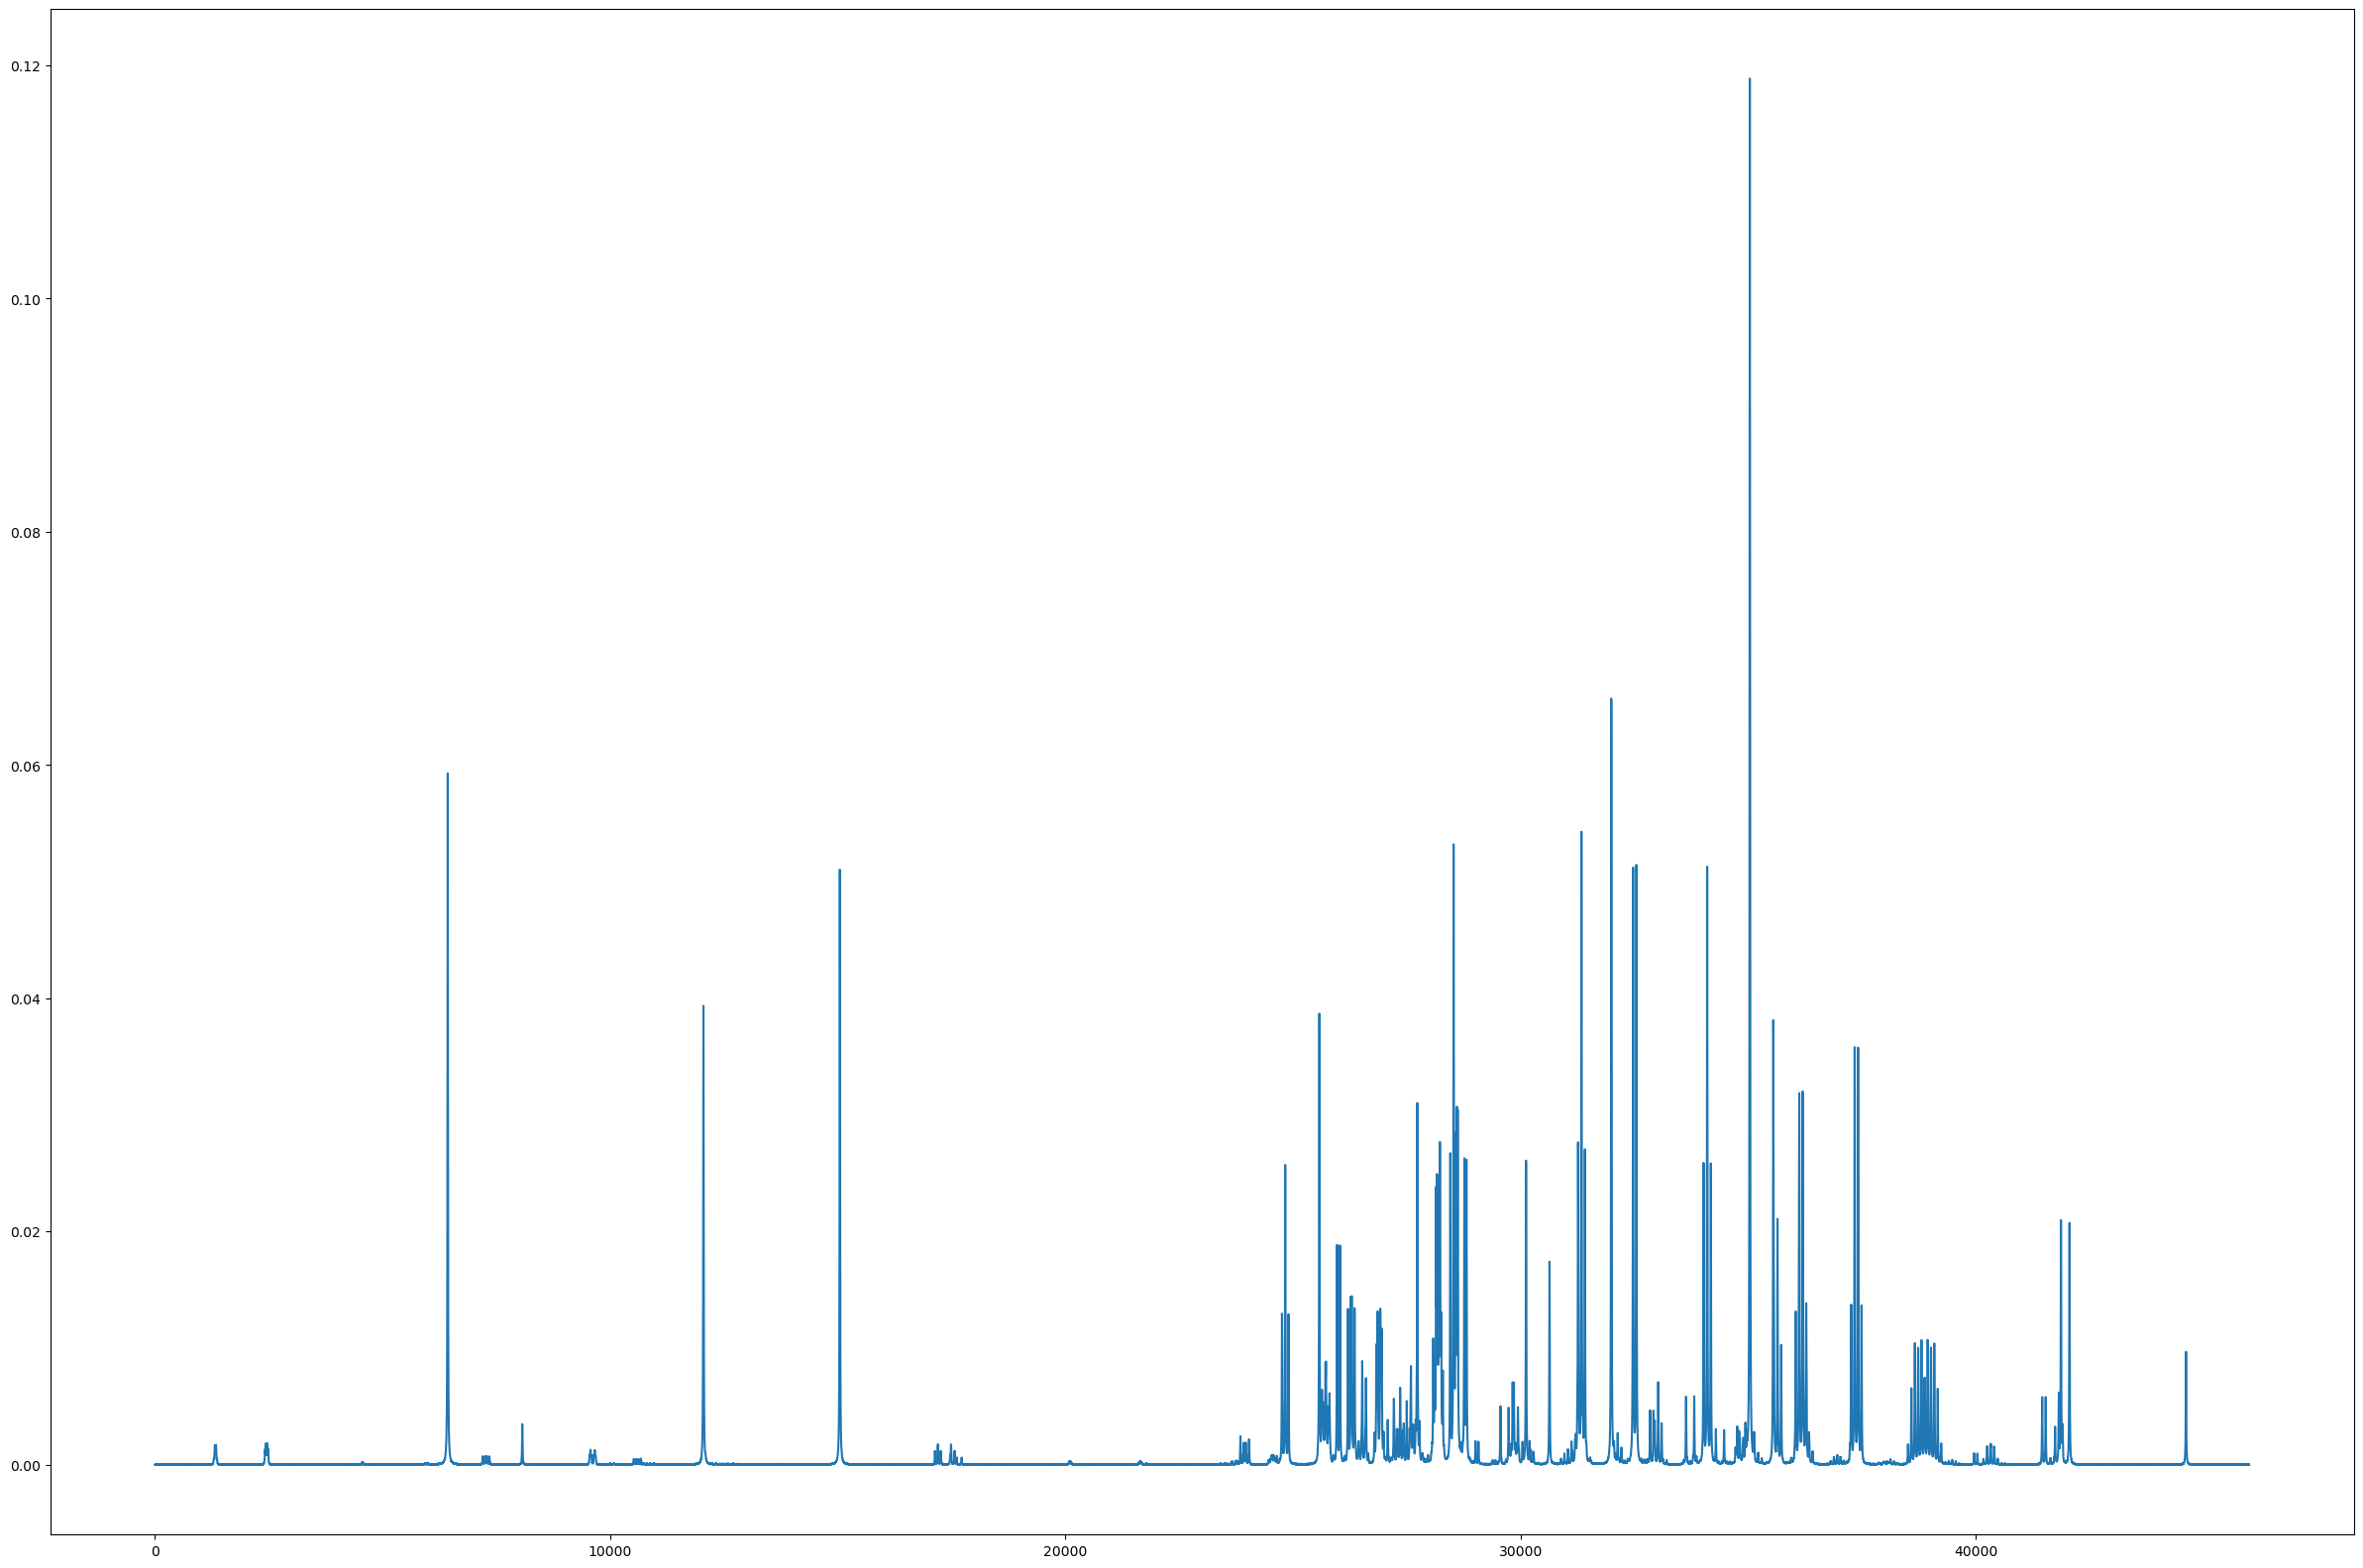

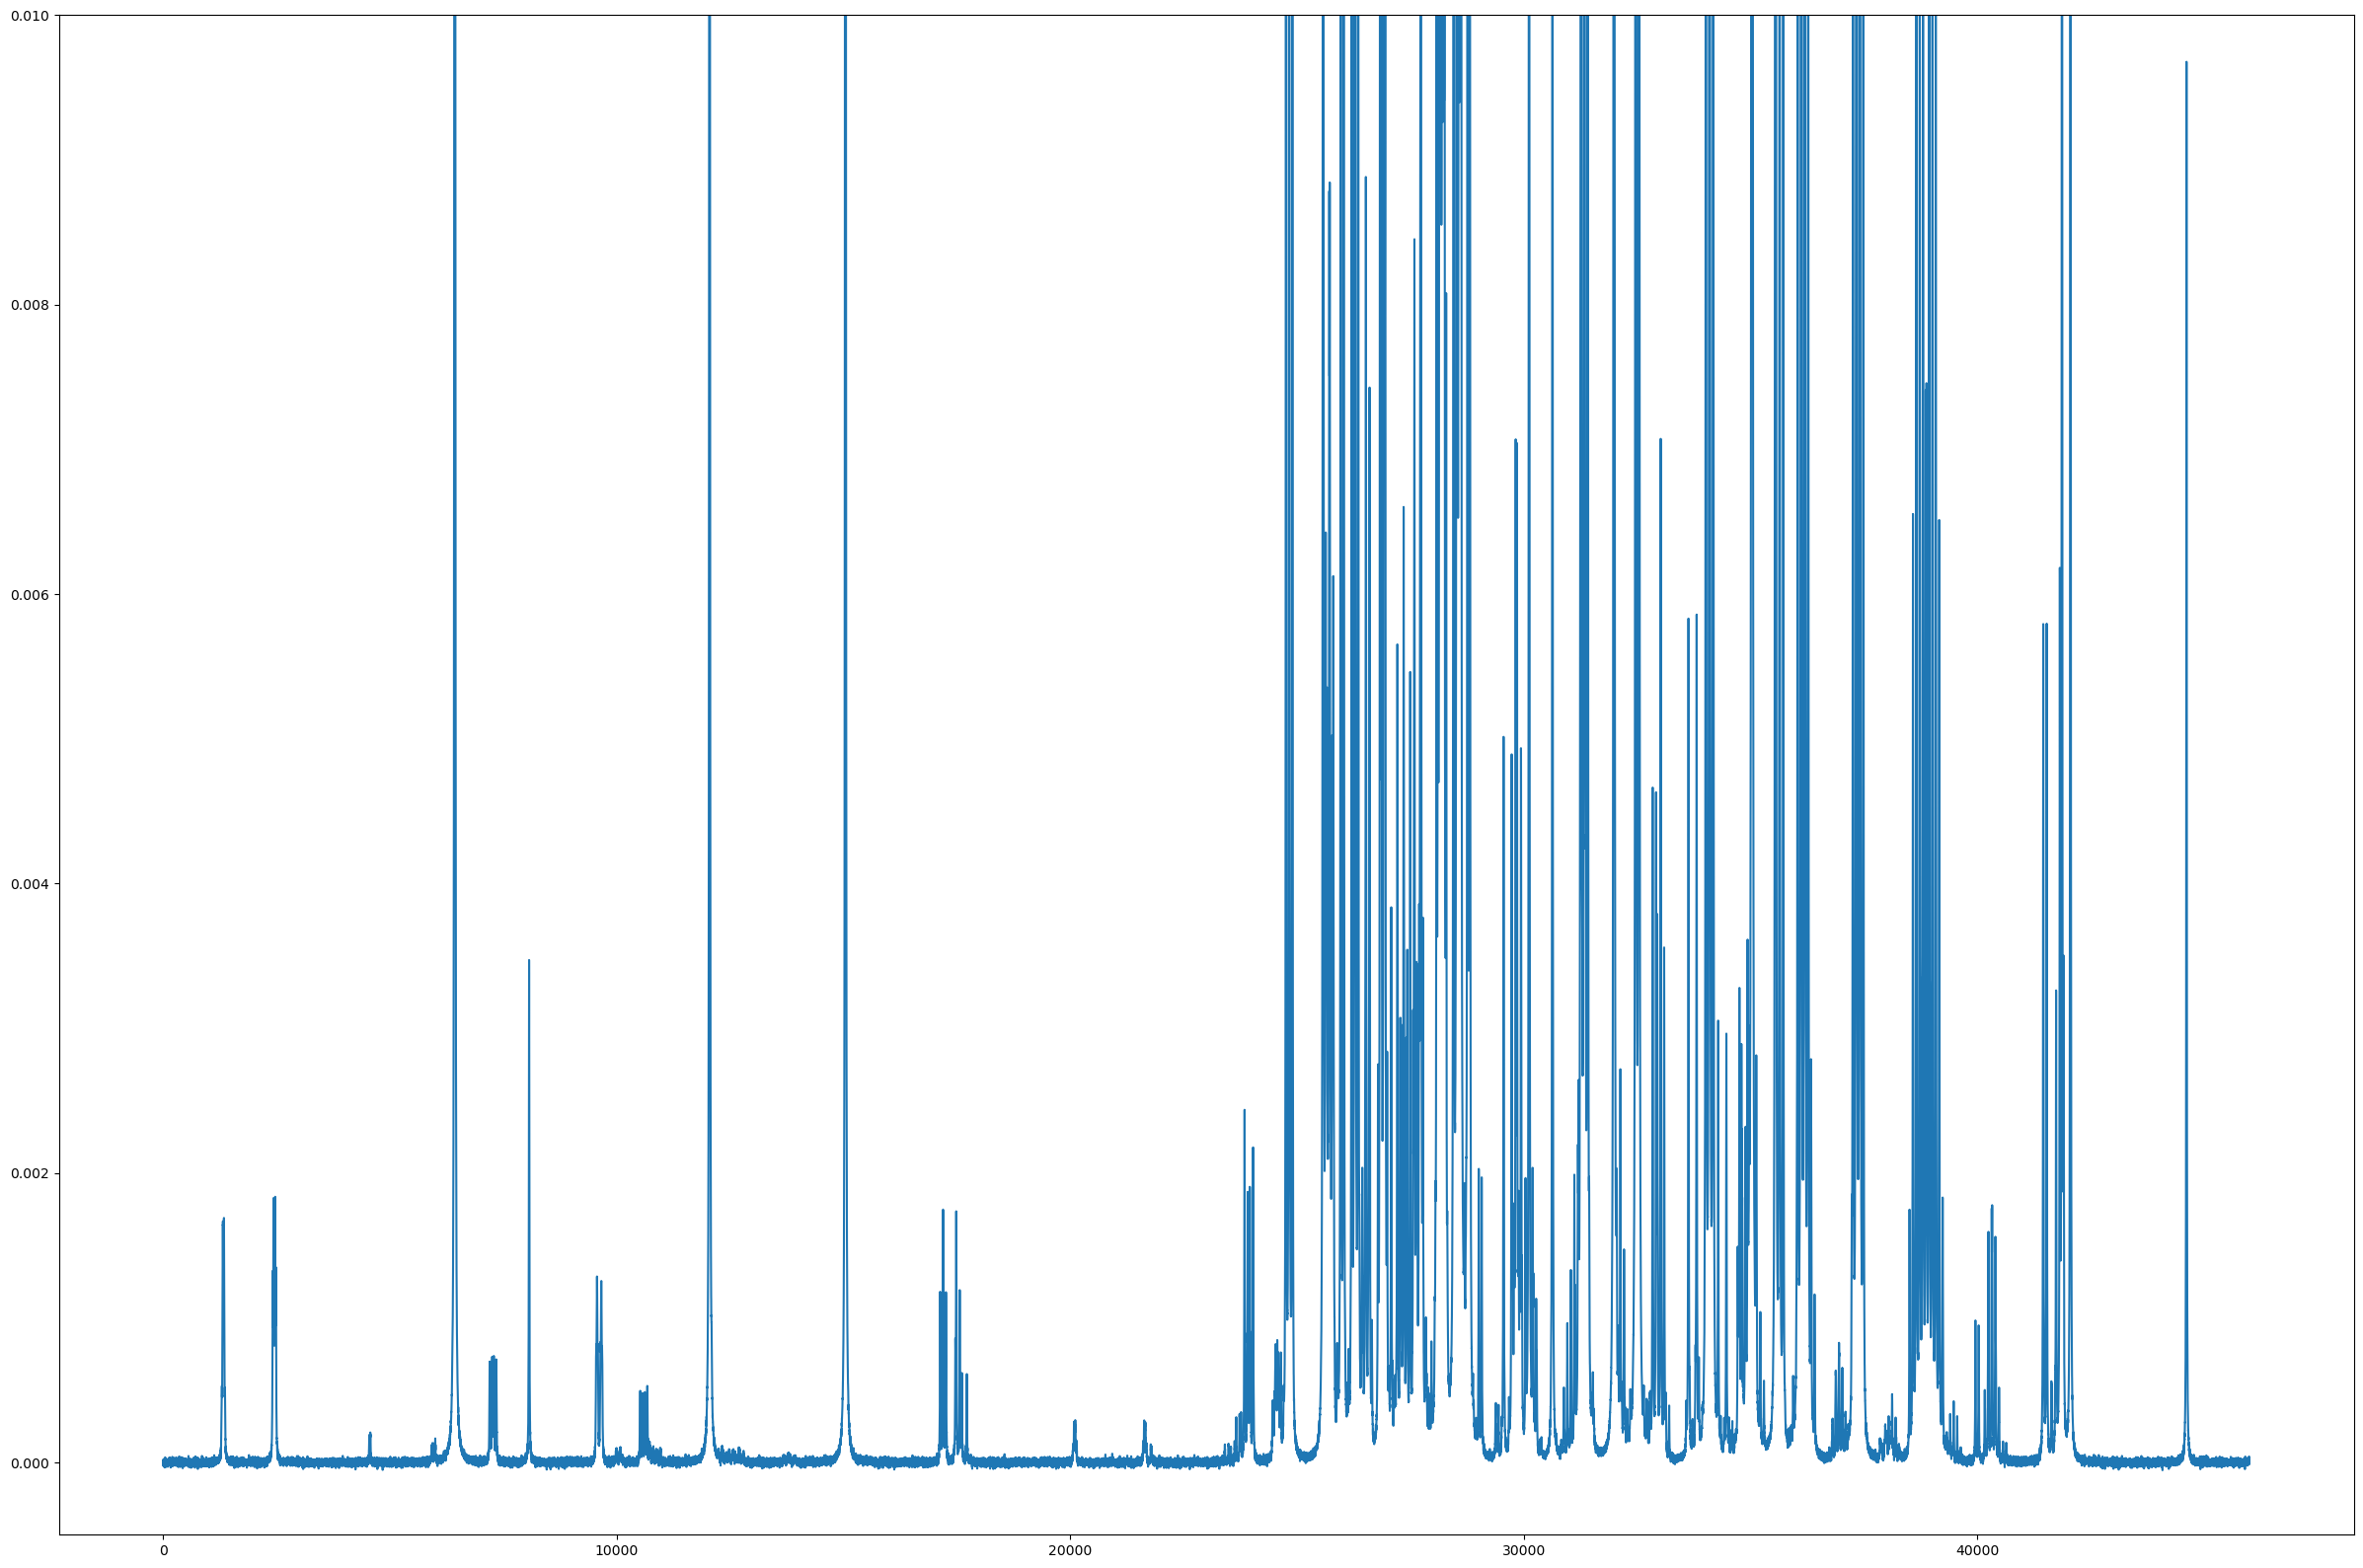

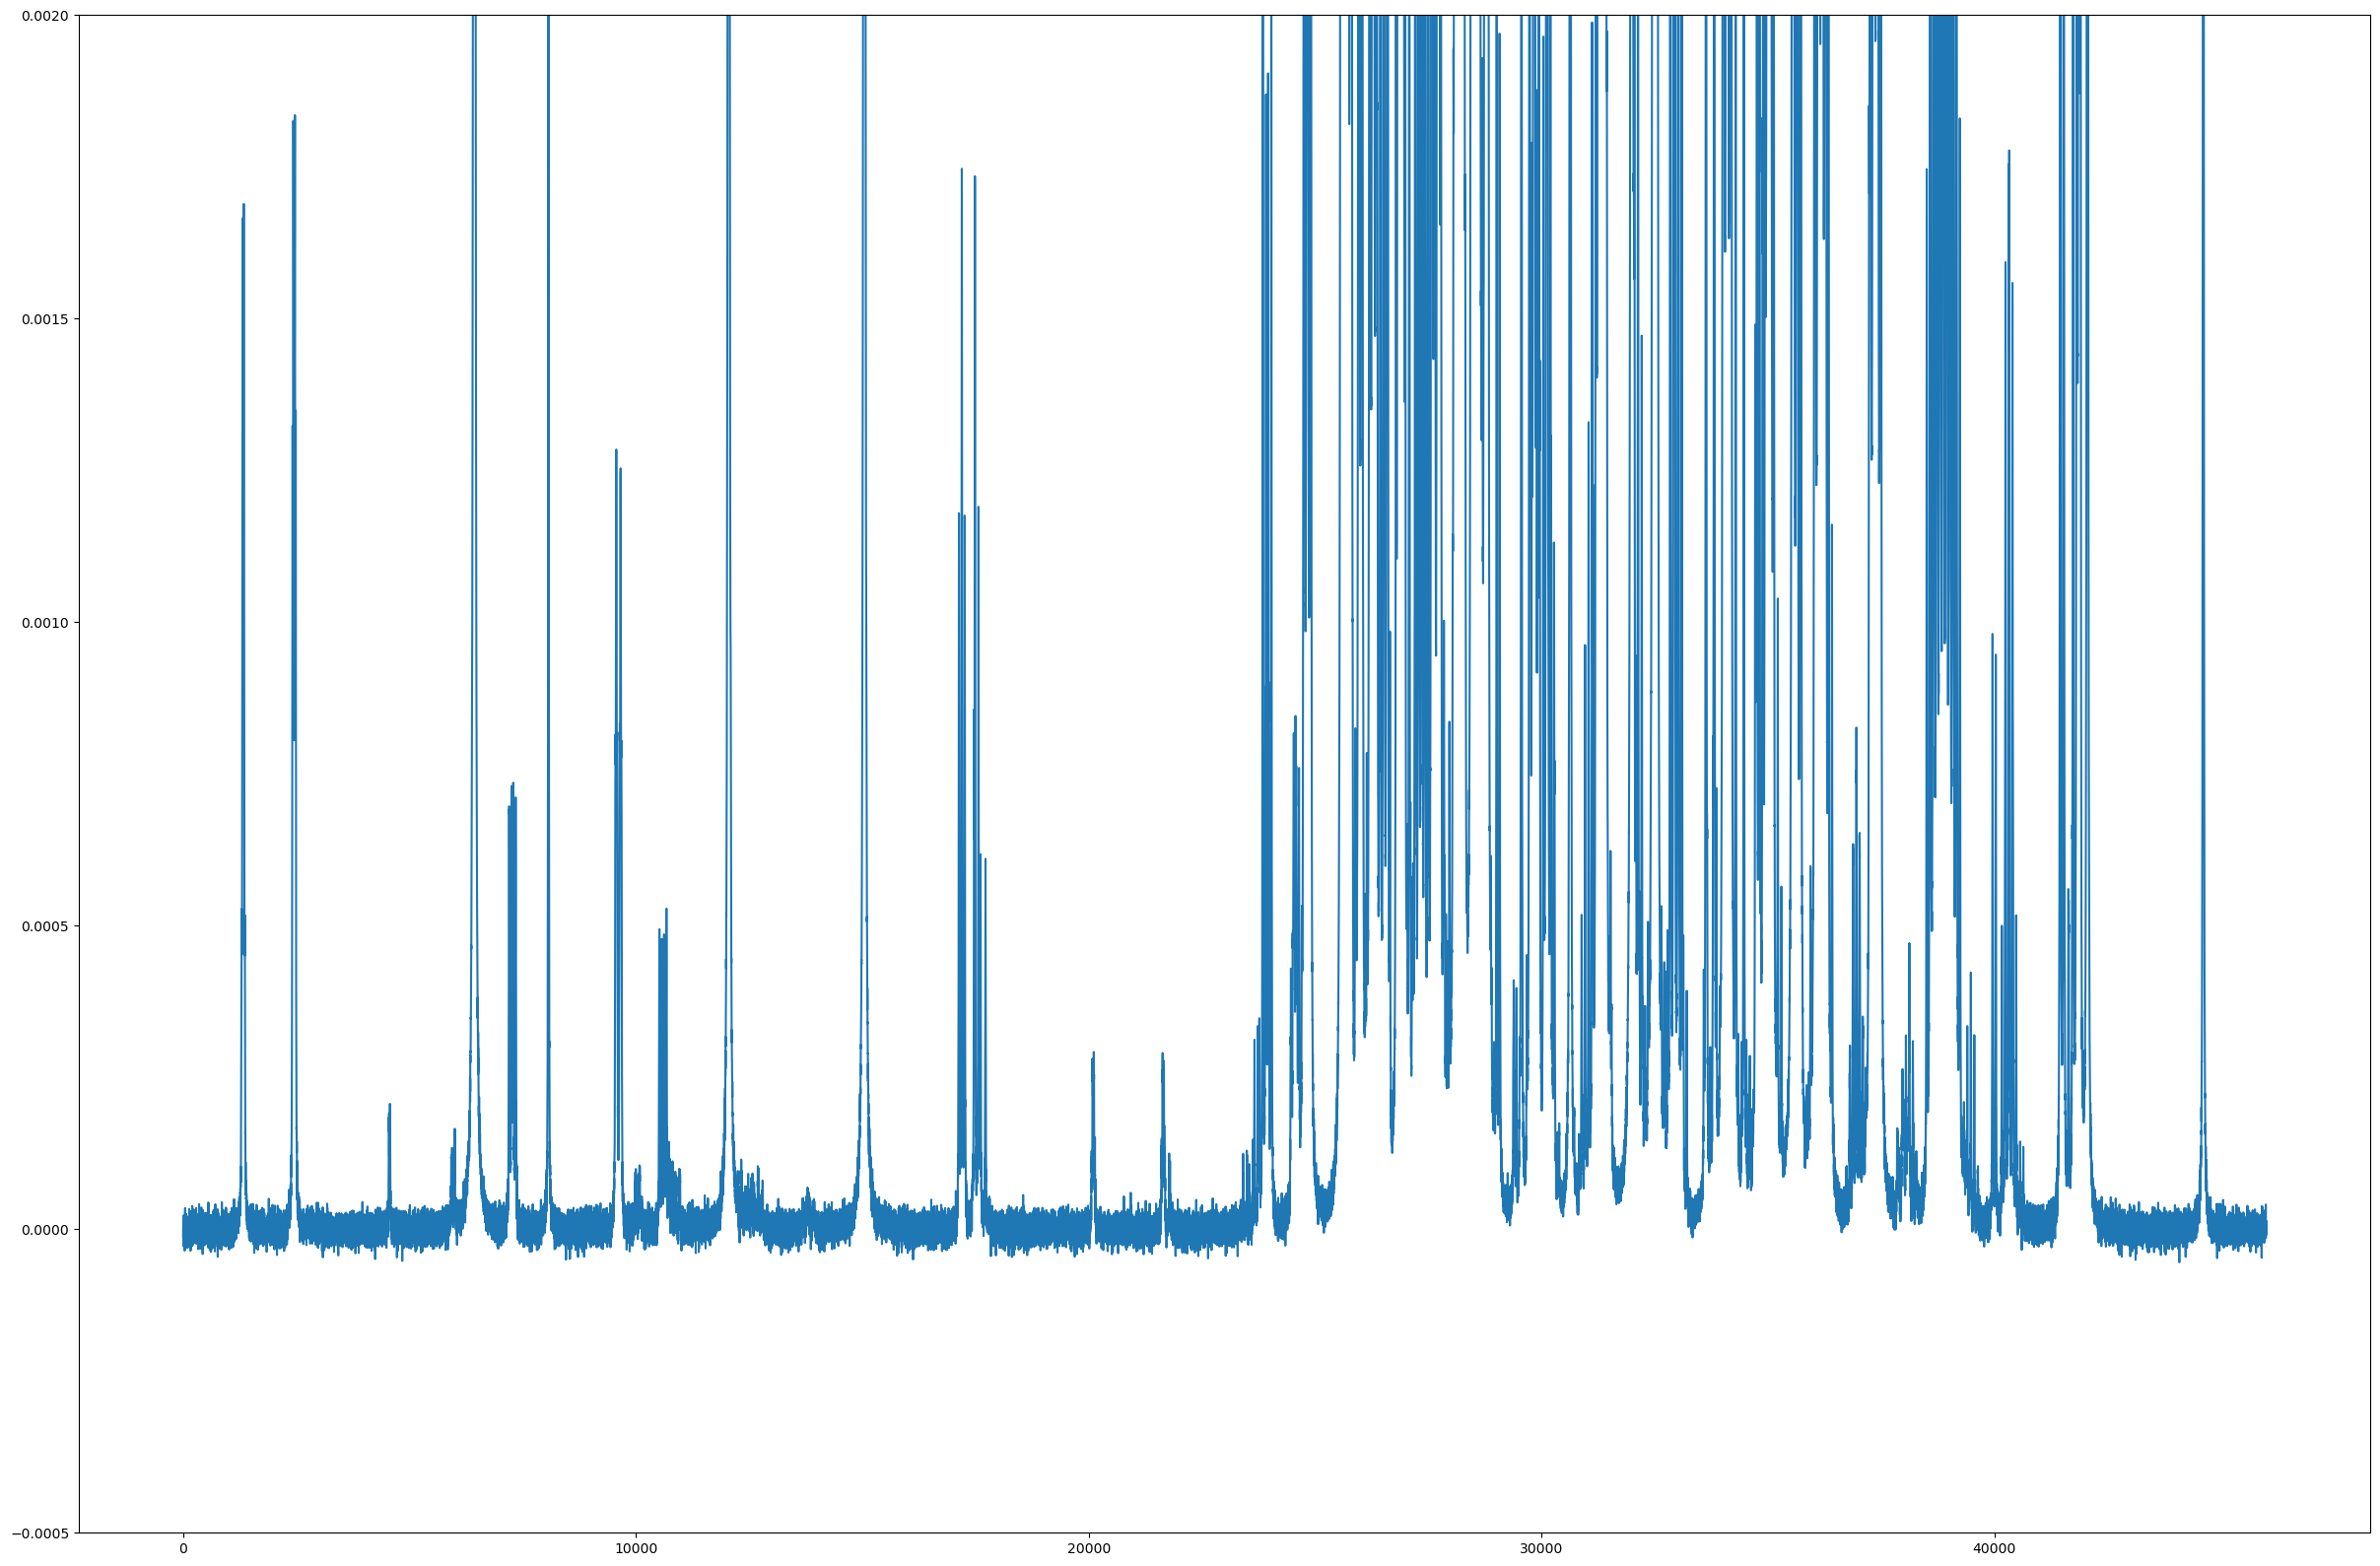

In [21]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [22]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  6.434485
--------------------
10.8  - Min Value: 0.0139  - Mean Value: 0.9
6.39  - Min Value: 0.0139  - Mean Value: 0.7
6.27  - Min Value: 0.0139  - Mean Value: 0.6
9.68  - Min Value: 0.0139  - Mean Value: 1.1
8.98  - Min Value: 0.0139  - Mean Value: 1.0
4.29  - Min Value: 0.0139  - Mean Value: 0.9
4.43  - Min Value: 0.0139  - Mean Value: 0.5
3.76  - Min Value: 0.0139  - Mean Value: 0.7
7.08  - Min Value: 0.0139  - Mean Value: 0.7
2.65  - Min Value: 0.0139  - Mean Value: 0.5


In [23]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  41.255653
--------------------
93.32  - Min Value: 0.0066  - Mean Value: 5.8
43.13  - Min Value: 0.0067  - Mean Value: 6.9
25.21  - Min Value: 0.0082  - Mean Value: 6.1
36.55  - Min Value: 0.0076  - Mean Value: 6.6
29.7  - Min Value: 0.0074  - Mean Value: 5.7
25.97  - Min Value: 0.01  - Mean Value: 6.6
24.73  - Min Value: 0.0113  - Mean Value: 7.9
38.57  - Min Value: 0.0059  - Mean Value: 7.3
35.13  - Min Value: 0.0069  - Mean Value: 7.6
60.25  - Min Value: 0.0083  - Mean Value: 6.7


In [24]:
ConcConc[5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [25]:
model_aq(ConcSpec[5])

tensor([[0.4944, 0.4986, 0.4992, 0.5036, 0.4985, 0.5019, 0.4936, 0.5013, 0.5017,
         0.4951, 0.5022, 0.5029, 0.4966, 0.4993, 0.4945, 0.5015, 0.5024, 0.4998,
         0.4979, 0.4994, 0.5046, 0.5002, 0.5082, 0.4999, 0.4983, 0.5035, 0.5037,
         0.4952, 0.5003, 0.4983, 0.5006, 0.5041, 0.4986, 0.5001, 0.5047, 0.5026,
         0.4960, 0.4955, 0.5032, 0.4973, 0.5005, 0.4957, 0.5012, 0.5044]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [33]:
ConcSpec.size()

torch.Size([10, 1, 46000])

In [34]:
SNR_Spec.size()

torch.Size([10, 1, 53500])

In [31]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x54784 and 47104x44)

In [28]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  14.488949886036849
--------------------
0.54
0.61
0.63
2.7
19.44
19.67
19.73
23.21
26.71
31.65


In [29]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  101.08350470394338
--------------------
8.77
30.04
50.74
71.75
92.24
112.24
131.99
151.53
171.45
190.08


In [30]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.4511, 0.6240, 0.2956, 0.5217, 0.5198, 0.4775, 0.5002, 0.5829, 0.6885,
        0.4250, 0.4123, 0.6940, 0.5209, 1.2526, 0.3211, 0.6941, 0.5933, 0.4655,
        0.4906, 0.3946, 0.4898, 0.8998, 0.2695, 0.5137, 0.5226, 0.5093, 0.5545,
        0.6428, 0.5313, 0.4753, 0.4371, 0.9419, 0.5025, 0.4220, 0.4209, 0.5515,
        0.4697, 0.4081, 0.7271, 0.3823, 0.3971, 0.4732, 0.5235, 0.4164],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.3962, 0.5745, 0.0000, 0.5387, 0.4130, 0.4440, 0.3931, 0.2521, 0.5197,
        0.5771, 0.4219, 0.5125, 0.8983, 0.0000, 0.6851, 0.0594, 0.8932, 0.5267,
        0.4167, 0.3781, 0.3530, 0.3905, 0.6979, 0.5888, 0.4515, 0.4861, 0.2891,
        0.0034, 0.5280, 0.4083, 0.4144, 0.2252, 0.2778, 0.5054, 0.6010, 0.4345,
        0.5440, 0.7903, 0.5143, 0.3204, 0.4207, 0.8677, 0.2609, 0.2090],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a